In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

#### Clean the Data

In [102]:
# Load data

df_comments = pd.read_csv('../data/toxicity_annotated_comments.tsv', sep = '\t')
df_score = pd.read_csv('../data/toxicity_annotations.tsv', sep = '\t')

In [103]:
df_comments.head()

,rev_id,comment,year,logged_in,ns,sample,split
0,2232.0,This:NEWLINE_TOKEN:One can make an analogy in ...,2002,True,article,random,train
1,4216.0,`NEWLINE_TOKENNEWLINE_TOKEN:Clarification for ...,2002,True,user,random,train
2,8953.0,Elected or Electoral? JHK,2002,False,article,random,test
3,26547.0,`This is such a fun entry. DevotchkaNEWLINE_...,2002,True,article,random,train
4,28959.0,Please relate the ozone hole to increases in c...,2002,True,article,random,test


In [104]:
df_score.head()

,rev_id,worker_id,toxicity,toxicity_score
0,2232.0,723,0,0.0
1,2232.0,4000,0,0.0
2,2232.0,3989,0,1.0
3,2232.0,3341,0,0.0
4,2232.0,1574,0,1.0


In [105]:
# View size of the data frames

print(f'Comments data frame: {df_comments.shape}')
print(f'Score data frame: {df_score.shape}')

Comments data frame: (159686, 7)
Score data frame: (1598289, 4)


In [106]:
# Turn the rev_id columns into an int

df_comments['rev_id'] = df_comments['rev_id'].astype(int)
df_score['rev_id'] = df_score['rev_id'].astype(int)

In [107]:
# Review if any columns have 0 toxicity values but negative toxicity scores

df_score[(df_score['toxicity'] == 0) & (df_score['toxicity_score'] < 0)]

,rev_id,worker_id,toxicity,toxicity_score


In [108]:
# Take the average of toxicity and toxicity score for each rev id

df_score_combined = df_score.groupby('rev_id').mean()

In [157]:
# Also take the sum of toxicity scores

df_score_sum = df_score.groupby('rev_id').sum()

In [159]:
df_score_sum.drop(columns = 'worker_id', inplace = True)

In [109]:
# Drop the worker id column

df_score_combined.drop(columns = 'worker_id', inplace = True)

In [110]:
df_score_combined.head()

,toxicity,toxicity_score
rev_id,,
2232,0.1,0.4
4216,0.0,0.5
8953,0.0,0.1
26547,0.0,0.6
28959,0.2,0.2


In [111]:
# Review if there are any descrepancies when scores are rolled up into one column

df_score_combined[(df_score_combined['toxicity'] == 0) & (df_score_combined['toxicity_score'] < 0)]

,toxicity,toxicity_score
rev_id,,


In [112]:
# Confirm the length of the scores table now matches the length of the comments table

print(f'Comments table: {df_comments.shape}')
print(f'Score table: {df_score.shape}')

Comments table: (159686, 7)
Score table: (1598289, 4)


In [113]:
# Join the two dataframes into one table

df = pd.merge(df_comments, df_score_combined, left_on = 'rev_id', right_on = 'rev_id', how = 'inner')

In [114]:
df.head()

,rev_id,comment,year,logged_in,ns,sample,split,toxicity,toxicity_score
0,2232,This:NEWLINE_TOKEN:One can make an analogy in ...,2002,True,article,random,train,0.1,0.4
1,4216,`NEWLINE_TOKENNEWLINE_TOKEN:Clarification for ...,2002,True,user,random,train,0.0,0.5
2,8953,Elected or Electoral? JHK,2002,False,article,random,test,0.0,0.1
3,26547,`This is such a fun entry. DevotchkaNEWLINE_...,2002,True,article,random,train,0.0,0.6
4,28959,Please relate the ozone hole to increases in c...,2002,True,article,random,test,0.2,0.2


In [160]:
# Also create a merged table with the scores sum

df_sum = pd.merge(df_comments, df_score_sum, left_on = 'rev_id', right_on = 'rev_id', how = 'inner')

In [115]:
# Drop the extra columns: year, logged_in, ns, sample, split

df.drop(columns = ['year', 'logged_in', 'ns', 'sample', 'split'], inplace = True)

In [116]:
# Check for any null values

df.isnull().sum()

rev_id            0
comment           0
toxicity          0
toxicity_score    0
dtype: int64

In [117]:
# Confirm data types

df.dtypes

rev_id              int64
comment            object
toxicity          float64
toxicity_score    float64
dtype: object

In [118]:
# Remove NEWLINE_TOKEN from the comments field

df['comment'].replace('NEWLINE_TOKEN', '', regex = True, inplace = True)

In [119]:
# Remove extra quotes (`)

df['comment'].replace('`', '', regex = True, inplace = True)

In [120]:
# Remove extra whitespace

df['comment'] = df['comment'].str.strip()

In [121]:
df.head()

,rev_id,comment,toxicity,toxicity_score
0,2232,This::One can make an analogy in mathematical ...,0.1,0.4
1,4216,":Clarification for you (and Zundark's right, ...",0.0,0.5
2,8953,Elected or Electoral? JHK,0.0,0.1
3,26547,This is such a fun entry. DevotchkaI once ha...,0.0,0.6
4,28959,Please relate the ozone hole to increases in c...,0.2,0.2


In [162]:
# Repeat cleaning steps on new sum dataframe as well

df_sum['comment'].replace('NEWLINE_TOKEN', '', regex = True, inplace = True)
df_sum['comment'].replace('`', '', regex = True, inplace = True)
df_sum['comment'] = df_sum['comment'].str.strip()

#### Visualization of the Fields

In [122]:
# Create a column to store the length of the comments

comment_length = []

# For each comment capture the length in the new list
for i in range(0, df.shape[0]):
    length = len(df['comment'][i])
    comment_length.append(length)

# Assign the lengths to a new columns
df['comment_length'] = comment_length

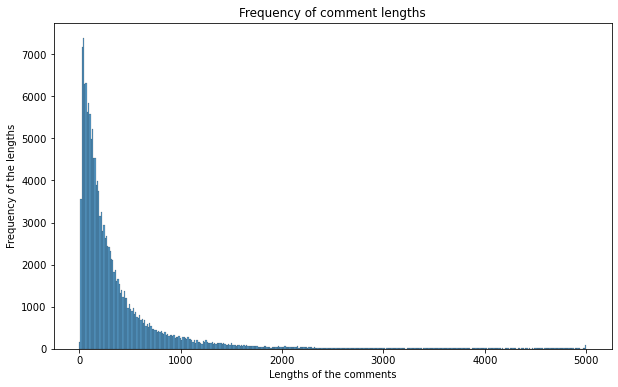

In [123]:
# View a histogram of the comment lengths

plt.figure(figsize = (10,6))
sns.histplot(df['comment_length'])
plt.title('Frequency of comment lengths')
plt.xlabel('Lengths of the comments')
plt.ylabel('Frequency of the lengths');

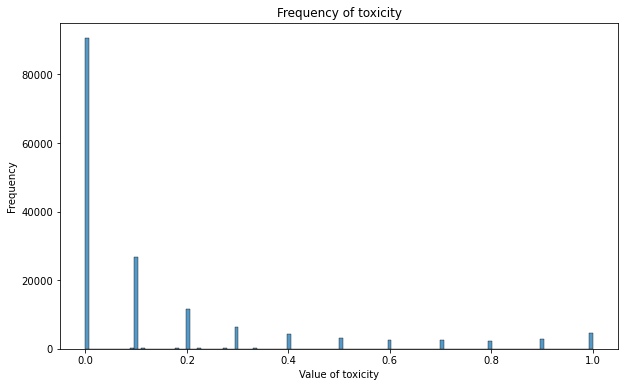

In [124]:
# View a histogram of the toxicity values

plt.figure(figsize = (10,6))
sns.histplot(df['toxicity'])
plt.title('Frequency of toxicity')
plt.xlabel('Value of toxicity')
plt.ylabel('Frequency');

In [125]:
# Map toxicity to be either 0 or 1 depending on if it's above or below 0.5

df['toxicity'] = (df['toxicity'] > 0.5).astype(int)
df['toxicity'].value_counts(normalize = True)

0    0.903799
1    0.096201
Name: toxicity, dtype: float64

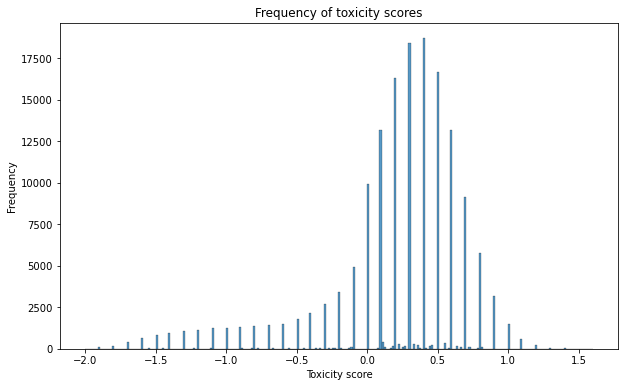

In [126]:
# View a histogram of the toxicity scores

plt.figure(figsize = (10,6))
sns.histplot(df['toxicity_score'])
plt.title('Frequency of toxicity scores')
plt.xlabel('Toxicity score')
plt.ylabel('Frequency');

In [127]:
# View most frequent phrases

df['comment'].value_counts()[:10]

Thank you for experimenting with  Wikipedia. Your test worked, and it has been reverted or removed. Please use the sandbox for any other tests you may want to do. Take a look at the welcome page to learn more about contributing to our encyclopedia.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       46
Please stop. If you continue to vandalize Wikipedia, you will be block

In [128]:
# Review toxicity score of bot comments

df[df['comment'] == 'Thank you for experimenting with  Wikipedia. Your test worked, and it has been reverted or removed. Please use the sandbox for any other tests you may want to do. Take a look at the welcome page to learn more about contributing to our encyclopedia.']

,rev_id,comment,toxicity,toxicity_score,comment_length
27456,83318068,Thank you for experimenting with Wikipedia. Y...,0,1.000000,248
27575,83621541,Thank you for experimenting with Wikipedia. Y...,0,0.500000,248
27884,84669720,Thank you for experimenting with Wikipedia. Y...,0,0.600000,248
28959,88102263,Thank you for experimenting with Wikipedia. Y...,0,1.000000,248
28965,88133235,Thank you for experimenting with Wikipedia. Y...,0,0.500000,248
29428,89509994,Thank you for experimenting with Wikipedia. Y...,0,1.000000,248
29456,89578766,Thank you for experimenting with Wikipedia. Y...,0,1.100000,248
29505,89748245,Thank you for experimenting with Wikipedia. Y...,0,0.900000,248
29712,90439084,Thank you for experimenting with Wikipedia. Y...,0,0.900000,248
30630,93347334,Thank you for experimenting with Wikipedia. Y...,0,0.700000,248


#### Tokenize Comments

In [129]:
# Instantiate RegExp Tokenizer

tokenizer = RegexpTokenizer(r'\w+')

In [130]:
# Tokenize words

token_list = []

for i in range(0, df.shape[0]):
    tokens = tokenizer.tokenize(df['comment'][i])
    token_list.append(tokens)

In [131]:
token_list[0]

['This',
 'One',
 'can',
 'make',
 'an',
 'analogy',
 'in',
 'mathematical',
 'terms',
 'by',
 'envisioning',
 'the',
 'distribution',
 'of',
 'opinions',
 'in',
 'a',
 'population',
 'as',
 'a',
 'Gaussian',
 'curve',
 'We',
 'would',
 'then',
 'say',
 'that',
 'the',
 'consensus',
 'would',
 'be',
 'a',
 'statement',
 'that',
 'represents',
 'the',
 'range',
 'of',
 'opinions',
 'within',
 'perhaps',
 'three',
 'standard',
 'deviations',
 'of',
 'the',
 'mean',
 'opinion',
 'sounds',
 'arbitrary',
 'and',
 'ad',
 'hoc',
 'Does',
 'it',
 'really',
 'belong',
 'in',
 'n',
 'encyclopedia',
 'article',
 'I',
 'don',
 't',
 'see',
 'that',
 'it',
 'adds',
 'anything',
 'useful',
 'The',
 'paragraph',
 'that',
 'follows',
 'seems',
 'much',
 'more',
 'useful',
 'Are',
 'there',
 'any',
 'political',
 'theorists',
 'out',
 'there',
 'who',
 'can',
 'clarify',
 'the',
 'issues',
 'It',
 'seems',
 'to',
 'me',
 'that',
 'this',
 'is',
 'an',
 'issue',
 'that',
 'Locke',
 'Rousseau',
 'de',
 '

In [132]:
# Count the length of the words

list_words = []

for i in range (0, len(token_list)):
    temp_list = []
    for word in token_list[i]:
        temp_list.append(len(word))
    list_words.append(temp_list)
        

In [133]:
# Add the maximum word count for each comment

word_max = []

for i in range(0, df.shape[0]):
    max_count = max(list_words[i], default = 0)
    word_max.append(max_count)

df['max_count'] = word_max

In [134]:
# View the longest words

df[df['max_count'] > 1000]

,rev_id,comment,toxicity,toxicity_score,comment_length,max_count
49074,160842894,== Discussion destroying CRAP topic ==It seems...,1,-0.500000,4958,4702
49836,164347157,== ==U R GAY== ==FUCKFUCKFUCKFUCKFUCKFUCKFUCKF...,1,-1.900000,4972,4955
59017,194432946,== jerk me jolly ==fuckfuckfuckfuckfuckfuckfuc...,1,-2.000000,1852,1833
66215,218363956,shut up you cuntWWWWWWWWWWWWWWWWWWWWWWWWWWWWWW...,1,-1.300000,4176,4164
84829,293236264,Small TextInsert non-formatted text here[[Medi...,0,0.000000,4472,1412
119443,459049021,== Gaaaaaaaaaaaaaaaaaaaaaaaaay! U r fucking ga...,1,-1.444444,4972,4920
124694,487872346,== Death To Wikipedia! Down with free Speach! ...,1,-0.700000,4972,4924
124695,487872381,== I shall purge this web site of the weak! ==...,1,-0.800000,4972,4926
124696,487872430,== Feel the might of Cyber Apocalypse! ==yyyyy...,0,0.000000,4972,4931
124697,487872506,== Your Web Site is As useless to the public a...,1,-0.900000,4972,4876


In [135]:
# Remove the comments with single words greater than 1000 characters

df = df[df['max_count'] < 1000]
df.reset_index(drop=True, inplace=True)

In [136]:
# Reset token list with words greater than 1000 characters removed

token_list = []

for i in range(0, df.shape[0]):
    tokens = tokenizer.tokenize(df['comment'][i])
    token_list.append(tokens)

#### Lemmatize Comments

In [137]:
# Instantiate lemmatizer

lemmatizer = WordNetLemmatizer()

In [138]:
# Lemmatize tokens

tokens_lem = []

for i in range(0, len(token_list)):
    token_temp = []
    for token in token_list[i]:
        tokens = lemmatizer.lemmatize(token)
        token_temp.append(tokens)
    tokens_lem.append(token_temp)

In [139]:
tokens_lem[0]

['This',
 'One',
 'can',
 'make',
 'an',
 'analogy',
 'in',
 'mathematical',
 'term',
 'by',
 'envisioning',
 'the',
 'distribution',
 'of',
 'opinion',
 'in',
 'a',
 'population',
 'a',
 'a',
 'Gaussian',
 'curve',
 'We',
 'would',
 'then',
 'say',
 'that',
 'the',
 'consensus',
 'would',
 'be',
 'a',
 'statement',
 'that',
 'represents',
 'the',
 'range',
 'of',
 'opinion',
 'within',
 'perhaps',
 'three',
 'standard',
 'deviation',
 'of',
 'the',
 'mean',
 'opinion',
 'sound',
 'arbitrary',
 'and',
 'ad',
 'hoc',
 'Does',
 'it',
 'really',
 'belong',
 'in',
 'n',
 'encyclopedia',
 'article',
 'I',
 'don',
 't',
 'see',
 'that',
 'it',
 'add',
 'anything',
 'useful',
 'The',
 'paragraph',
 'that',
 'follows',
 'seems',
 'much',
 'more',
 'useful',
 'Are',
 'there',
 'any',
 'political',
 'theorist',
 'out',
 'there',
 'who',
 'can',
 'clarify',
 'the',
 'issue',
 'It',
 'seems',
 'to',
 'me',
 'that',
 'this',
 'is',
 'an',
 'issue',
 'that',
 'Locke',
 'Rousseau',
 'de',
 'Toquevill

In [140]:
# Compare tokens to lemmatized version

first_term = list(zip(token_list[0], tokens_lem[0]))

In [141]:
# See which words the lemmatizer changed in first comment

[tup for tup in first_term if tup[0] != tup[1]]

[('terms', 'term'),
 ('opinions', 'opinion'),
 ('as', 'a'),
 ('opinions', 'opinion'),
 ('deviations', 'deviation'),
 ('sounds', 'sound'),
 ('adds', 'add'),
 ('theorists', 'theorist'),
 ('issues', 'issue')]

#### Stem Comments

In [142]:
# Instantiate PorterStemmer

p_stemmer = PorterStemmer()

In [143]:
# Stem tokens

tokens_stem = []

for i in range(0, len(token_list)):
    token_temp = []
    for token in token_list[i]:
        tokens = p_stemmer.stem(token)
        token_temp.append(tokens)
    tokens_stem.append(token_temp)

In [144]:
tokens_stem[0]

['thi',
 'one',
 'can',
 'make',
 'an',
 'analog',
 'in',
 'mathemat',
 'term',
 'by',
 'envis',
 'the',
 'distribut',
 'of',
 'opinion',
 'in',
 'a',
 'popul',
 'as',
 'a',
 'gaussian',
 'curv',
 'we',
 'would',
 'then',
 'say',
 'that',
 'the',
 'consensu',
 'would',
 'be',
 'a',
 'statement',
 'that',
 'repres',
 'the',
 'rang',
 'of',
 'opinion',
 'within',
 'perhap',
 'three',
 'standard',
 'deviat',
 'of',
 'the',
 'mean',
 'opinion',
 'sound',
 'arbitrari',
 'and',
 'ad',
 'hoc',
 'doe',
 'it',
 'realli',
 'belong',
 'in',
 'n',
 'encyclopedia',
 'articl',
 'i',
 'don',
 't',
 'see',
 'that',
 'it',
 'add',
 'anyth',
 'use',
 'the',
 'paragraph',
 'that',
 'follow',
 'seem',
 'much',
 'more',
 'use',
 'are',
 'there',
 'ani',
 'polit',
 'theorist',
 'out',
 'there',
 'who',
 'can',
 'clarifi',
 'the',
 'issu',
 'it',
 'seem',
 'to',
 'me',
 'that',
 'thi',
 'is',
 'an',
 'issu',
 'that',
 'lock',
 'rousseau',
 'de',
 'toquevil',
 'and',
 'other',
 'must',
 'have',
 'debat',
 'sr

In [145]:
# Compare tokens to stemmed version

first_term = list(zip(token_list[0], tokens_stem[0]))

In [146]:
# See which words the stemmer changed in first comment

[tup for tup in first_term if tup[0] != tup[1]]

[('This', 'thi'),
 ('One', 'one'),
 ('analogy', 'analog'),
 ('mathematical', 'mathemat'),
 ('terms', 'term'),
 ('envisioning', 'envis'),
 ('distribution', 'distribut'),
 ('opinions', 'opinion'),
 ('population', 'popul'),
 ('Gaussian', 'gaussian'),
 ('curve', 'curv'),
 ('We', 'we'),
 ('consensus', 'consensu'),
 ('represents', 'repres'),
 ('range', 'rang'),
 ('opinions', 'opinion'),
 ('perhaps', 'perhap'),
 ('deviations', 'deviat'),
 ('sounds', 'sound'),
 ('arbitrary', 'arbitrari'),
 ('Does', 'doe'),
 ('really', 'realli'),
 ('article', 'articl'),
 ('I', 'i'),
 ('adds', 'add'),
 ('anything', 'anyth'),
 ('useful', 'use'),
 ('The', 'the'),
 ('follows', 'follow'),
 ('seems', 'seem'),
 ('useful', 'use'),
 ('Are', 'are'),
 ('any', 'ani'),
 ('political', 'polit'),
 ('theorists', 'theorist'),
 ('clarify', 'clarifi'),
 ('issues', 'issu'),
 ('It', 'it'),
 ('seems', 'seem'),
 ('this', 'thi'),
 ('issue', 'issu'),
 ('Locke', 'lock'),
 ('Rousseau', 'rousseau'),
 ('Toqueville', 'toquevil'),
 ('others',

#### Vectorize Words

In [147]:
# Instantiate and fit the transformer

cvec = CountVectorizer(stop_words = 'english', token_pattern = r'\w+', strip_accents = 'ascii')

In [148]:
# Convert comments to dataframe to run vectorizer

X = df['comment']
X_df = pd.DataFrame(cvec.fit_transform(X).todense(), columns = cvec.get_feature_names())

In [149]:
X_df.head()

,0,00,000,0000,00000,000000,0000000,00000000,0000000027,00000001,...,zzzz,zzzzall,zzzzz,zzzzzzz,zzzzzzzzzzzzzzzzz,zzzzzzzzzzzzzzzzzzzzz,zzzzzzzzzzzzzzzzzzzzzzzzzzzzzz,zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz,zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz,zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [150]:
df[df['comment'].str.contains('zzzzzzzzzzzzzzzzzzzzzzzzzzzzzz')]

,rev_id,comment,toxicity,toxicity_score,comment_length,max_count
63871,209757656,Dont Change It!!!! zzzzzzzzzzzzzzzzzzzzzzzzzzz...,0,-0.375,5000,150
120420,464044185,Aargh - it's past 1 AM here and I need to be u...,1,-0.800,264,57


In [151]:
df[df['comment'].str.contains('00000001')]

,rev_id,comment,toxicity,toxicity_score,comment_length,max_count
1321,8737219,"Welcome!Hello, and welcome to Wikipedia. Thank...",0,0.6,688,30
68742,227373690,Factually incorrect information? How many art...,0,0.6,1723,38
126704,498836728,== WP:AFC on Marathonios ==Note: The following...,0,0.4,2526,22
147362,623371825,==German New Medicine==Because there is an alm...,0,0.1,668,16


In [155]:
df['comment'].iloc[68742]

'Factually incorrect information?  How many articles from reputable sources do you want that Emilio Pucci created Capri pants?Here are just a few:http://dlxs.lib.wayne.edu/d/dhhcc/bios/pucci.htmlhttp://dept.kent.edu/museum/exhibit/pucci/pucci2.htmlhttp://www.nytimes.com/2007/08/26/style/tmagazine/26pucci.htmlhttp://www.ultimateitaly.com/fashion/emilio-pucci.htmlhttp://www.handbags-online.us/emilio-pucci.htmlhttp://www.fashionmodeldirectory.com/designers/Emilio+Pucci/http://reviews.ebay.com/Emilio-Pucci-A-Guide-to-Emilio-Pucci-amp-Fashion_W0QQugidZ10000000001022967http://www.poandpo.com/design-art-and-nice-stuff/puccis-coloured-swirls/The unverifiable claims were the ones that I set out to remove from Wikipedia - the claims that a heretofore unheard-of Sonja de Lennart, who was completely unknown on Google until December 2007, created Capri pants.Originally there was one site given as a source for the Sonja de Lennart claims - www.sonjadelennart.com, a site owned by Eleonora de Lennart 

In [167]:
# Review most negative comments

df_sum[df_sum['toxicity_score'] <= -30]

,rev_id,comment,year,logged_in,ns,sample,split,toxicity,toxicity_score
7526,31084135,YOU FUCKING SUCK I HATE YOUR FUCKING SITE IT S...,2005,False,user,random,test,20,-35.0
23891,72706312,== FUCK YOU ==I MOTHERFUCKING HAVE BEEN TRYING...,2006,False,user,random,train,20,-32.0
37396,116974456,"Yeah I believe it, how many times have I heard...",2007,True,user,random,train,20,-31.0
37964,118887736,== Really Realy fucking boring ==YOu are a bor...,2007,True,user,random,train,20,-31.0
66926,220833841,== suck my dick ==fuck you dirty whore bitch,2008,False,user,random,train,20,-31.0
106212,389652702,== Fuck You. ==Fuck you. That's his middle nam...,2010,False,user,random,train,19,-31.0
142605,597624231,dolescum you are a stupid motherfucker,2014,True,user,random,train,20,-32.0


In [175]:
# Review most positive comments

df_sum[df_sum['toxicity_score'] > 15]

,rev_id,comment,year,logged_in,ns,sample,split,toxicity,toxicity_score
29054,88410637,Good job done with Fernando Gago article! Keep...,2006,True,user,random,train,0,17.0
30958,94467733,"Welcome!Hello, , and welcome to Wikipedia! Tha...",2006,True,user,random,train,0,16.0
42845,137607381,::Thank you ) I am très excited! Review me!,2007,True,user,random,train,0,17.0
68696,227256046,== Good progress ==Your group is making very g...,2008,True,user,random,dev,0,16.0


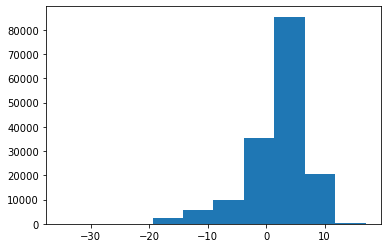

In [169]:
plt.hist(df_sum['toxicity_score']);

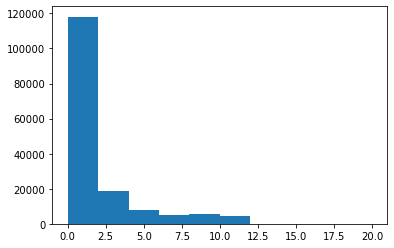

In [170]:
plt.hist(df_sum['toxicity']);

In [172]:
df_sum.describe()

,rev_id,year,toxicity,toxicity_score
count,1.596860e+05,159686.000000,159686.000000,159686.000000
mean,3.005779e+08,2009.224159,1.453196,2.051069
std,1.987478e+08,2.910620,2.547054,5.046041
min,2.232000e+03,2001.000000,0.000000,-35.000000
25%,1.263791e+08,2007.000000,0.000000,1.000000
50%,2.714297e+08,2009.000000,0.000000,3.000000
75%,4.606385e+08,2011.000000,2.000000,5.000000
max,6.998972e+08,2016.000000,20.000000,17.000000


In [174]:
df_score[df_score['rev_id'] == 597624231]

,rev_id,worker_id,toxicity,toxicity_score
1427458,597624231,2299,1,-2.0
1427459,597624231,2497,1,-2.0
1427460,597624231,201,1,-1.0
1427461,597624231,58,1,-2.0
1427462,597624231,121,1,-2.0
1427463,597624231,153,1,-1.0
1427464,597624231,2546,1,-1.0
1427465,597624231,226,1,-2.0
1427466,597624231,434,1,-2.0
1427467,597624231,697,1,-1.0
